In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

print("We're using TF", tf.__version__)

We're using TF 2.19.0


In [2]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

''

In [3]:
#GPU count and name
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU (UUID: GPU-3475a7c0-6d55-f941-cc80-6275c950be62)


In [4]:
# Загрузка данных
images = np.load('mds-misis-dl-captchan/images.npy')
labels = np.load('mds-misis-dl-captchan/labels.npy')
images_sub = np.load('mds-misis-dl-captchan/images_sub.npy') # Тестовый набор для предсказания

In [5]:
# Размерность датасета
print(images.shape)
print(labels.shape)

(20000, 48, 48, 3)
(20000,)


Набор картинок выглядит, как набор матриц 48x48. Набор состоит из 20000 картинок, с 3 каналами.

In [6]:
# Нормализация пикселей
images = images.astype('float32') / 255.0
images_sub = images_sub.astype('float32') / 255.0

# Проверка типа данных и диапазона
print(f"Диапазон пикселей после нормализации: {images.min()} - {images.max()}")

Диапазон пикселей после нормализации: 0.0 - 1.0


Пример картинки:


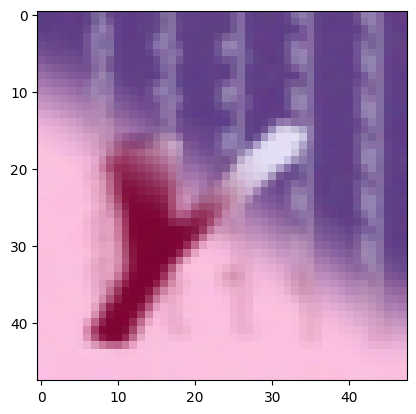

Это класс: Y


In [7]:
# Визуализация картинки
train_image = images[1]
print("Пример картинки:")
plt.imshow(train_image)
plt.show()
print(f"Это класс: {chr(65 + labels[1])}") # 65 - код буквы 'A' в ASCII

In [8]:
num_classes = len(np.unique(labels)) # количество выходов для классификации
num_classes

26

In [9]:
# one-hot encode для ответов
labels_oh = keras.utils.to_categorical(labels, num_classes)
labels_oh.shape

(20000, 26)

In [10]:
# Деление датасет на трейни вал для отслеживания переобучения
X_train, X_val, y_train, y_val = train_test_split(images, labels_oh, test_size=0.2, random_state=42)
print(f"Обучающая выборки (X_train): {X_train.shape}")
print(f"Валидационная выборки (X_val): {X_val.shape}")# стандартно берём 20%

Обучающая выборки (X_train): (16000, 48, 48, 3)
Валидационная выборки (X_val): (4000, 48, 48, 3)


Необходимо расширить датасет с помощью аугментации, так как буковки могут быть смещены, повернуты и модель также должна хорошо их классифицировать.

In [84]:
# Определяем аугментацию
transform_letter = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,          # Случайный поворот на 20 градусов
    width_shift_range=0.15,      # Случайный сдвиг по горизонтали (15% от ширины)
    height_shift_range=0.15,     # Случайный сдвиг по вертикали (15% от высоты)
    shear_range=0.1,            # Случайное срезание (наклон)
    zoom_range=0.1,             # Случайное увеличение/уменьшение
    horizontal_flip=False,      # Не переворачиваем по горизонтали
    fill_mode='nearest'         # Стратегия заполнения новых пикселей
)
transform_letter.fit(X_train)

In [233]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
input_shape
epochs = 50 # подобран вручную

In [234]:
# собираем модель
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='valid')) # После этого слоя картинка стала 46x46
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid')) # После этого слоя картинка стала 23x23
model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="valid")) # После этого слоя картинка стала 21x21
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=3, padding='valid')) # После этого слоя картинка стала 7x7
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same')) # После этого слоя картинка стала 7x7
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')) # После этого слоя картинка стала 7x7
model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same')) # После этого слоя картинка стала 7x7
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')) # После этого слоя картинка стала 7x7
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation='softmax')) # для классификации, обеспечивая вероятностное представление выходов

В свёрточных нейронных сетях принято использовать слои свёртки, батч-нормализации, пулинг-слои и дропауты (в качестве регуляризации).

    - Регуляризации (Dropout, BatchNorm) для устойчивого обучения.
    - Оптимальная глубина: 4 сверточных слоя извлекают полезные признаки, но не усложняет модель.
    - Softmax — естественный выбор для многоклассовой классификации.

In [235]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,578 (998.35 KB)

 Trainable params: 254,874 (995.60 KB)

 Non-trainable params: 704 (2.75 KB)

In [236]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),  # минимизируем кросс-энтропию
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']  # выводим процент правильных ответов
)

Дополнение weight decay (AdamW) помогает избегать чрезмерного накопления весов и действует более эффективно, чем L2-регуляризация в стандартном Adam

In [237]:
print("Training...")
history = model.fit(
    transform_letter.flow(X_train, y_train, batch_size=256),
    validation_data=(X_val, y_val),
    epochs=epochs
)

Training...
Epoch 1/50


D:\PythonProjects\.venv3.12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.0446 - loss: 4.2547 - val_accuracy: 0.0302 - val_loss: 3.2740
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.0501 - loss: 3.4580 - val_accuracy: 0.0373 - val_loss: 3.2874
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.0545 - loss: 3.3165 - val_accuracy: 0.0362 - val_loss: 3.2898
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.0663 - loss: 3.2240 - val_accuracy: 0.0318 - val_loss: 3.3048
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.1169 - loss: 3.0089 - val_accuracy: 0.0890 - val_loss: 3.1134
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.1939 - loss: 2.7348 - val_accuracy: 0.1420 - val_loss: 2.8665
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.2805 - loss: 2.3828 - val_accuracy: 0.2968 - val_loss: 2.4994
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.3821 - loss: 2.0582 - val_accuracy: 0.398

In [238]:
print("Evaluating...")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Валидационная потеря: {val_loss:.4f}")
print(f"Валидационная точность: {val_accuracy:.4f}")

Evaluating...
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9297 - loss: 0.2440
Валидационная потеря: 0.2589
Валидационная точность: 0.9227


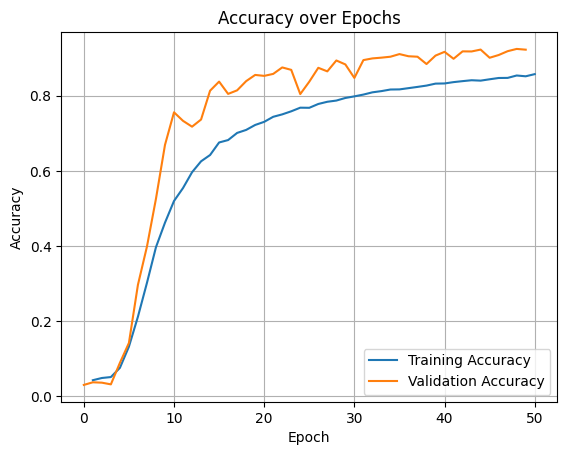

In [239]:
# Выводим графики для оценки не переобучилась ли модель
plt.plot(range(1, epochs+1), history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

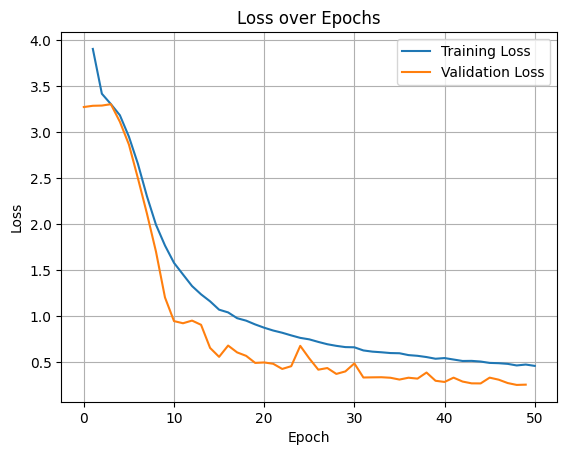

In [240]:
# Выводим графики для оценки не переобучилась ли модель
plt.plot(range(1, epochs+1), history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [243]:
print("Predicting...")
y_pred = model.predict(images_sub) # предикт

Predicting...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


In [244]:
print("Creating submission...")
submission = pd.read_csv('mds-misis-dl-captchan/sample_submission.csv')
labels = np.argmax(y_pred, axis=1)
submission["Category"] = labels
submission.to_csv('submission.csv', index=False) # формирование сабмишена

Creating submission...
